## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 6s 117us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - acc: 0.0979 - val_loss: 2.4627 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (

50000/50000 [==============================] - 6s 116us/step - loss: 2.6777 - acc: 0.6275 - val_loss: 2.9067 - val_acc: 0.5326
Epoch 50/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.6367 - acc: 0.6332 - val_loss: 2.9377 - val_acc: 0.5172
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1

50000/50000 [==============================] - 6s 116us/step - loss: 0.8603 - acc: 0.7004 - val_loss: 1.5527 - val_acc: 0.4929
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__________________________________

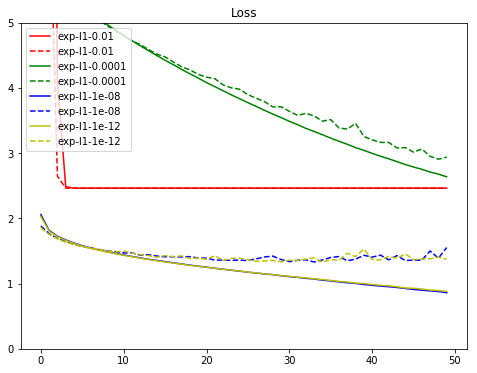

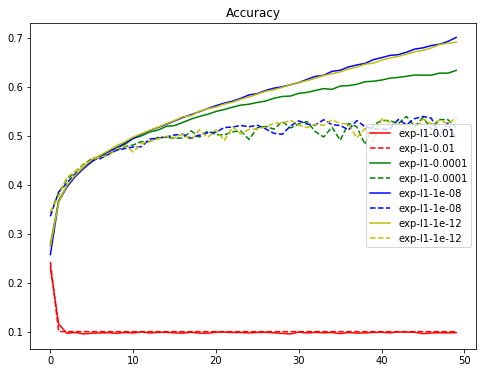

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 129us/step - loss: 18.8058 - acc: 0.2631 - val_loss: 17.3654 - val_acc: 0.3364
Epoch 2/50
50000/50000 [==============================] - 6s 118us/step - loss: 16.1482 - acc: 0.3532 - val_loss: 14.9817 - val_acc: 0.3705
Epoch 3/50
50000/50000 [==============================] - 6s 119us/step - loss: 13.9586 - acc: 0.3791 - val_loss: 12.9730 - val_acc: 0.3862
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 12.1070 - acc: 0.3945 - val_loss: 11.2784 - val_acc: 0.3963
Epoch 5/50
50000/50000 [==============================] - 6s 118us/step - loss: 10.5350 - acc: 0.4053 - val_loss: 9.8236 - val_acc: 0.4130
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 9.1971 - acc: 0.4122 - val_loss: 8.5982 - val_acc: 0.4138
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 8.0583 - acc: 0.4179 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 6s 118us/step - loss: 13.0258 - acc: 0.3560 - val_loss: 12.1339 - val_acc: 0.3677
Epoch 3/50
50000/50000 [==============================] - 6s 119us/step - loss: 11.3512 - acc: 0.3817 - val_loss: 10.6011 - val_acc: 0.3902
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 9.9405 - acc: 0.3946 - val_loss: 9.3025 - val_acc: 0.3997
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 8.7418 - acc: 0.4048 - val_loss: 8.2012 - val_acc: 0.4038
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 7.7180 - acc: 0.4111 - val_loss: 7.2663 - val_acc: 0.4109
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 6.8458 - acc: 0.4179 - val_loss: 6.4556 - val_acc: 0.4170
Epoch 8/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.1016 - acc: 0.4244 - val_loss: 5.7724 - val_acc: 0.4175
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 6s 119us/step - loss: 11.3369 - acc: 0.3816 - val_loss: 10.5889 - val_acc: 0.3896
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 9.9250 - acc: 0.3989 - val_loss: 9.2917 - val_acc: 0.3939
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 8.7270 - acc: 0.4051 - val_loss: 8.1866 - val_acc: 0.4111
Epoch 6/50
50000/50000 [==============================] - 6s 119us/step - loss: 7.7045 - acc: 0.4133 - val_loss: 7.2471 - val_acc: 0.4210
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.8335 - acc: 0.4218 - val_loss: 6.4369 - val_acc: 0.4274
Epoch 8/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.0904 - acc: 0.4267 - val_loss: 5.7557 - val_acc: 0.4291
Epoch 9/50
50000/50000 [==============================] - 6s 119us/step - loss: 5.4557 - acc: 0.4308 - val_loss: 5.1695 - val_acc: 0.4326
Epoch 10/50
50000/50000 [==================

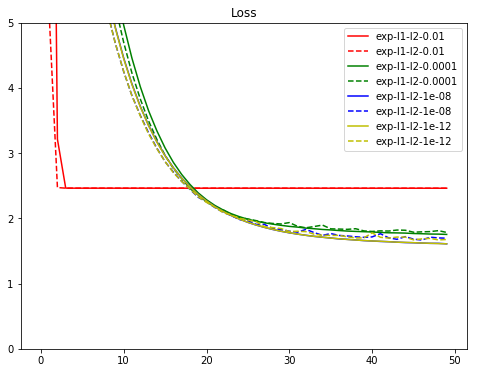

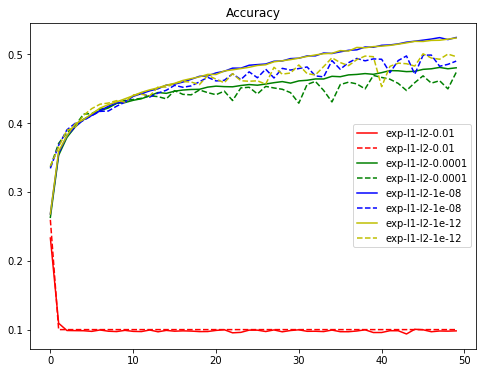

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()